**This workbook will aim at implementing an example use this cryptobacktest library**

The strategy we aim to implement is an options-based approach designed to capture potential increases in the volatility of the underlying asset. Specifically, we will utilize a strategy known as a straddle, which involves simultaneously purchasing a call and a put option with the same strike price and expiration date. This setup allows us to profit from significant price movements in either direction. To identify potential opportunities, we will focus on periods of low volatility, anticipating that an increase in volatility may follow.

In [64]:
import cryptobacktest
from cryptobacktest import Option

import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pybacktestchain
from pybacktestchain.data_module import *
from cryptobacktest.vol import *

In [121]:
# Define the date range
start_date = "2016-01-01"
end_date = "2024-12-31"

# Import historical data thanks to a pybacktestchain function
btc_data = get_stock_data('BTC-USD', start_date, end_date)
btc_data

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,BTC-USD
1,2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,BTC-USD
2,2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,BTC-USD
3,2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,BTC-USD
4,2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,BTC-USD
...,...,...,...,...,...,...,...,...
3282,2024-12-26 00:00:00+00:00,99297.695312,99884.570312,95137.882812,95795.515625,95795.515625,47054980873,BTC-USD
3283,2024-12-27 00:00:00+00:00,95704.976562,97294.843750,93310.742188,94164.859375,94164.859375,52419934565,BTC-USD
3284,2024-12-28 00:00:00+00:00,94160.187500,95525.898438,94014.289062,95163.929688,95163.929688,24107436185,BTC-USD
3285,2024-12-29 00:00:00+00:00,95174.054688,95174.875000,92881.789062,93530.226562,93530.226562,29635885267,BTC-USD


We will be working on the closing prices so we will only keep them.

In [124]:
# Set Date as the index
btc_close = btc_data[['Date', 'Close']].copy()

btc_close['Date'] = pd.to_datetime(btc_close['Date']).dt.strftime('%Y-%m-%d')
btc_close.set_index('Date', inplace=True)

# Display the DataFrame
btc_close

,Close
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991
...,...
2024-12-26,95795.515625
2024-12-27,94164.859375
2024-12-28,95163.929688


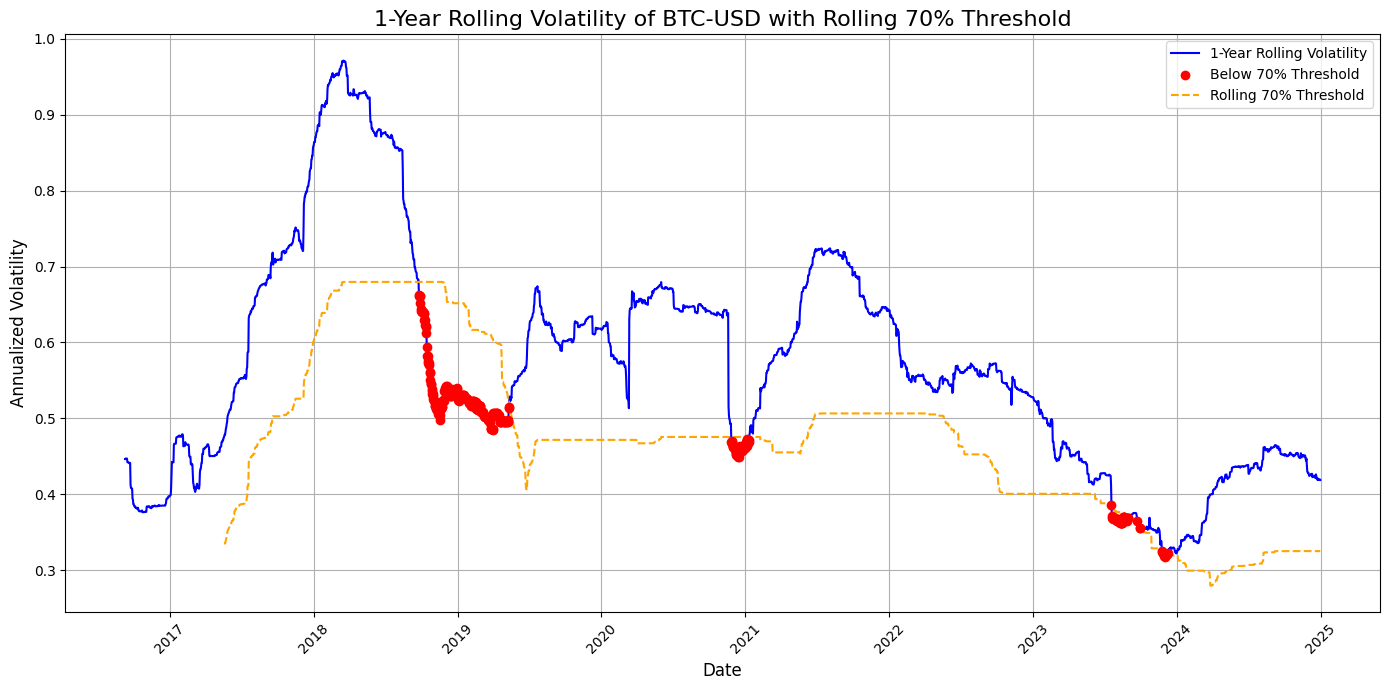

In [52]:

# Step 1: Calculate daily returns
btc_close['Daily_Return'] = btc_close['BTC-USD'].pct_change()

# Step 2: Compute 1-year (252 trading days) rolling volatility
btc_close['Rolling_Volatility'] = btc_close['Daily_Return'].rolling(window=252).std() * np.sqrt(252)

# Step 3: Compute rolling 70% threshold (based on the maximum volatility over the past 252 days)
btc_close['Rolling_Threshold'] = 0.7 * btc_close['Rolling_Volatility'].rolling(window=252).max()

# Step 4: Identify points where volatility drops below the rolling threshold
btc_close['Below_Threshold'] = btc_close['Rolling_Volatility'] < btc_close['Rolling_Threshold']

# Step 5: Plot the rolling volatility and mark points below the rolling threshold
plt.figure(figsize=(14, 7))
plt.plot(btc_close['Date'], btc_close['Rolling_Volatility'], label='1-Year Rolling Volatility', color='blue')

# Add red dots for points below the rolling threshold
plt.scatter(btc_close.loc[btc_close['Below_Threshold'], 'Date'],
            btc_close.loc[btc_close['Below_Threshold'], 'Rolling_Volatility'],
            color='red', label='Below 70% Threshold', zorder=5)

# Add a rolling orange line for the 70% threshold
plt.plot(btc_close['Date'], btc_close['Rolling_Threshold'], color='orange', linestyle='--', label='Rolling 70% Threshold')

# Add labels, title, and legend
plt.title('1-Year Rolling Volatility of BTC-USD with Rolling 70% Threshold', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annualized Volatility', fontsize=12)
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()